# Multi-Class Classification with Transformer Encoder

## 1. Loading helper modules & functions

In [1]:
%load_ext autoreload
%autoreload 2
import torch as T
import torch.nn as nn
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torchinfo
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"  # Set the GPU 2 to use
device = T.device("cuda" if T.cuda.is_available() else "cpu")
device2 = T.device("cuda:1" if T.cuda.is_available() else "cpu")
# device = T.device("cpu")
# from encoding.parallel import DataParallelModel, DataParallelCriterion

from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix
metric_collection = MetricCollection([
    # MulticlassAccuracy(num_classes=4, average="none").to(device),
    MulticlassPrecision(num_classes=4, average="none").to(device),
    MulticlassRecall(num_classes=4, average="none").to(device),
    MulticlassF1Score(num_classes=4, average="none").to(device),
])
metric_collection_weighted = MetricCollection([
    # MulticlassAccuracy(num_classes=4, average="weighted").to(device),
    MulticlassPrecision(num_classes=4, average="weighted").to(device),
    MulticlassRecall(num_classes=4, average="weighted").to(device),
    MulticlassF1Score(num_classes=4, average="weighted").to(device),
])
import sklearn.datasets
import umap
import umap.plot
 
import shap
import scipy as sp
# import transformers
print("Pytorch version:", T.__version__, "CUDA version:", T.version.cuda, "cuDNN version:", T.backends.cudnn.version())
print("device:", device, T.cuda.get_device_name(0), ", device2:", device2, T.cuda.get_device_name(1))

Pytorch version: 1.12.1 CUDA version: 11.3 cuDNN version: 8302
device: cuda NVIDIA RTX A6000 , device2: cuda:1 NVIDIA RTX A6000


## 2. Implementing the Backbone of Transformer-based Classifier

In [2]:
hf = h5py.File('STAD_Dataset3_Train.h5', 'r')
print(hf.keys())

# X_Train = np.array(hf.get('X_Train')).astype('int64')
X_Train = np.array(hf.get('X_Train'))
Y_Train = np.array(hf.get('Y_Train')).astype('int8')
print('X_Train.shape : ', X_Train.shape)
print('Y_Train.shape : ', Y_Train.shape)

hf.close()
X_Train.dtype, Y_Train.dtype

<KeysViewHDF5 ['X_Train', 'Y_Train']>
X_Train.shape :  (325, 1501)
Y_Train.shape :  (325,)


(dtype('<f8'), dtype('int8'))

In [3]:
hf = h5py.File('STAD_Dataset3_Test.h5', 'r')
print(hf.keys())
# X_Test = np.array(hf.get('X_Test')).astype('int64')
X_Test = np.array(hf.get('X_Test'))
Y_Test = np.array(hf.get('Y_Test')).astype('int8')

print('X_Test.shape  : ', X_Test.shape)
print('Y_Test.shape  : ', Y_Test.shape)

hf.close()
X_Test.dtype, Y_Test.dtype

<KeysViewHDF5 ['X_Test', 'Y_Test']>
X_Test.shape  :  (82, 1501)
Y_Test.shape  :  (82,)


(dtype('<f8'), dtype('int8'))

In [4]:
class STAD_Dataset(T.utils.data.Dataset):
    def __init__(self, src_file):
        hf = h5py.File(src_file, 'r')
        if 'X_Train' in hf.keys() :
            # X = np.array(hf.get('X_Train')).astype('int64')
            X = np.array(hf.get('X_Train'))
            Y = np.array(hf.get('Y_Train')).astype('int8')
        else :
            # X = np.array(hf.get('X_Test')).astype('int64')
            X = np.array(hf.get('X_Test'))
            Y = np.array(hf.get('Y_Test')).astype('int8')
        hf.close()

        # self.x_data = T.tensor(X, dtype=T.int64).to(device)
        self.x_data = T.tensor(X, dtype=T.float32).to(device)
        self.y_data = T.tensor(Y, dtype=T.int64).to(device)  

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx] 
        return x, y  

In [5]:
class STAD_Dataset2(T.utils.data.Dataset):
    def __init__(self, src_file):
        hf = h5py.File(src_file, 'r')
        if 'X_Train' in hf.keys() :
            # X = np.array(hf.get('X_Train')).astype('int64')
            X = np.array(hf.get('X_Train'))
            Y = np.array(hf.get('Y_Train')).astype('int8')
        else :
            # X = np.array(hf.get('X_Test')).astype('int64')
            X = np.array(hf.get('X_Test'))
            Y = np.array(hf.get('Y_Test')).astype('int8')
        hf.close()

        # self.x_data = T.tensor(X, dtype=T.int64).to(device2)
        self.x_data = T.tensor(X, dtype=T.float32).to(device2)
        self.y_data = T.tensor(Y, dtype=T.int64).to(device2)  

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx] 
        return x, y  

In [6]:
# 오리지널 트랜스포머의 embedding layer를 대체하는 특수 레이어 함수
# 데이터가 텍스트가 아닌 실수이고 이를 그대로 살리려면 기존과는 다른 방식이 필요
class Special_Embedding_Layer(T.nn.Module):

    class Core(T.nn.Module):
        def __init__(self, n):
            super().__init__()
            self.weights = T.nn.Parameter(T.zeros((n, 1), dtype=T.float32))
            self.biases = T.nn.Parameter(T.tensor(n, dtype=T.float32))
            lim = 0.01
            T.nn.init.uniform_(self.weights, -lim, lim)
            T.nn.init.zeros_(self.biases)
      
        def forward(self, x):
            wx = T.mm(x, self.weights.t())
            v = T.add(wx, self.biases)
            return v
    

    def __init__(self, n_in, n_out):
        super().__init__()
        self.n_in = n_in; self.n_out = n_out
        if n_out % n_in != 0:
            print("Warning: n_out ought be divisible by n_in")
        n = n_out // n_in
        self.lst_modules = T.nn.ModuleList([Special_Embedding_Layer.Core(n) for i in range(n_in)])


    def forward(self, x):
        lst_nodes = []
        for i in range(self.n_in):
            xi = x[:,i].reshape(-1, 1)
            oupt = self.lst_modules[i](xi)
            lst_nodes.append(oupt)

        # for i in range(1, self.n_in):
        #     result = T.cat((result, lst_nodes[i]), 1)
        # 위와 같이 하면 이상하게 두 번째 것만 붙고 나머지는 안 되어서 할 수 없이 나눠서 함
        result = T.cat((lst_nodes[0], lst_nodes[1]), 1)
        for i in range(2, self.n_in):
            result = T.cat((result, lst_nodes[i]), 1)
        result = result.reshape(-1, self.n_out)

        return result

In [7]:
class PositionalEncoding(T.nn.Module):  
    def __init__(self, d_model: int, dropout: float=0.1, max_len: int=1501):
        super(PositionalEncoding, self).__init__()  
        self.dropout = T.nn.Dropout(p=dropout)
        pe = T.zeros(max_len, d_model)  
        position = T.arange(0, max_len, dtype=T.float32).unsqueeze(1)
        div_term = T.exp(T.arange(0, d_model, 2).float() * (-np.log(10_000.0) / d_model))
        pe[:, 0::2] = T.sin(position * div_term)
        pe[:, 1::2] = T.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # 이게 없으면 나중에 forward 에서 pe값을 못 찾아 에러남

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [8]:
# E = number of cases that all features can express in integer (feature=token) 
# D = #Embedding Dimension ; I = #input features ; F = #fc1 layer hidden nodes ; drop = dropout rate
E = 320 ; D = 8 ; I = 1501 ; F = 8 ; drop = 0.1
class Transformer_Classifier(T.nn.Module):  # 1501 -> 1501*D -> Transformer -> F -> 4
    def __init__(self):
        super(Transformer_Classifier, self).__init__() 
        # numeric pseudo-embedding, dim=D
        # self.embed = Special_Embedding_Layer(I, I*D)  # I input features, each goes to D 
        self.embed = T.nn.Embedding(E, D)  # I input features, each goes to D
        self.pos_enc = PositionalEncoding(D, dropout=drop)  # positional embedding
        self.enc_layer = T.nn.TransformerEncoderLayer(d_model=D, nhead=4, dim_feedforward=D, 
                         dropout=drop, batch_first=True)  # d_model should be divisible by nhead
        self.trans_enc = T.nn.TransformerEncoder(self.enc_layer, num_layers=3)  # default 6 layers 
        # STAD Dataset has I input features per each sample
        self.dropout = nn.Dropout(drop)
        # self.fc1 = T.nn.Linear(D*I, F)  # F hidden nodes
        # self.fc2 = T.nn.Linear(F, 4)    # 4 classes
        self.fc3 = T.nn.Linear(D*I, 4)    # 4 classes (GX, G1, G2, G3)

    def forward(self, x):
        # x = I input features, fixed length
        z = self.embed(x.int())  # I inputs to I*D embeds
        z = z.reshape(-1, I, D) 
        z = self.pos_enc(z) 
        z = self.trans_enc(z) 
        z = z.reshape(-1, D*I)  # torch.Size([batch_size, D*I])
        # z = self.dropout(z)
        # z = self.fc1(z)
        # z = T.tanh(z)
        z = self.dropout(z)
        z = self.fc3(z)
        z = T.log_softmax(z, dim=1)  # later followed by NLL Loss()
        return z

In [10]:
net = Transformer_Classifier().to(device)
net

Transformer_Classifier(
  (embed): Embedding(320, 8)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
    )
    (linear1): Linear(in_features=8, out_features=8, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=8, out_features=8, bias=True)
    (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (trans_enc): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_fe

In [12]:
batchsize = 1
torchinfo.summary(net, input_size=(batchsize, 1501),  dtypes=[T.long],
col_names=["input_size","output_size","num_params","params_percent","trainable"])
# col_names=["input_size","output_size","num_params","params_percent","kernel_size","mult_adds","trainable"]

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Param %                   Trainable
Transformer_Classifier                        [1, 1501]                 [1, 4]                    464                         0.88%                   True
├─Embedding: 1-1                              [1, 1501]                 [1, 1501, 8]              2,560                       4.88%                   True
├─PositionalEncoding: 1-2                     [1, 1501, 8]              [1, 1501, 8]              --                             --                   --
│    └─Dropout: 2-1                           [1, 1501, 8]              [1, 1501, 8]              --                             --                   --
├─TransformerEncoder: 1-3                     [1, 1501, 8]              [1, 1501, 8]              --                             --                   True
│    └─ModuleList: 2-2                        --                     

## 3. Training model

### 3-1. Lodaing Dataset

In [9]:
# def main():
# 0. setup
print("\nBegin Transformer Classifier with STAD samples ")
np.random.seed(1)  
T.manual_seed(1)  

# 1. create Dataset
train_file = "./STAD_Dataset3_Train.h5"
train_ds = STAD_Dataset(train_file)
print("\n", len(train_ds), "training dataset created from an h5 file")

test_file = "./STAD_Dataset3_Test.h5"
test_ds = STAD_Dataset(test_file)
print("\n", len(test_ds), "test dataset created from an h5 file")

bat_size = 10
train_ldr = T.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)


Begin Transformer Classifier with STAD samples 

 325 training dataset created from an h5 file

 82 test dataset created from an h5 file


In [10]:
# def main():
# 0. setup
print("\nBegin Transformer Classifier with STAD samples ")
np.random.seed(1)  
T.manual_seed(1)  

# 1. create Dataset
train_file = "./STAD_Dataset3_Train.h5"
train_ds2 = STAD_Dataset2(train_file)
print("\n", len(train_ds2), "training dataset created from an h5 file")

test_file = "./STAD_Dataset3_Test.h5"
test_ds2 = STAD_Dataset2(test_file)
print("\n", len(test_ds2), "test dataset created from an h5 file")

bat_size = 10
train_ldr2 = T.utils.data.DataLoader(train_ds2, batch_size=bat_size, shuffle=True)


Begin Transformer Classifier with STAD samples 

 325 training dataset created from an h5 file

 82 test dataset created from an h5 file


### 3-2. Training model

In [225]:
print("\nCreating Transformer network ")
# net = Transformer_Classifier().to(device)
net = nn.DataParallel(Transformer_Classifier()).to(device)
# net = DataParallelModel(Transformer_Classifier()).to(device) # for Multi-GPU 
# net.double() # 모델 내 데이터들을 전체적으로 float32에서 float64로 만들어 줌. 대신 훈련시간 6배 더 걸림.
# net.half() # float16으로 만들어 주어서 정말 GPU가 반만 드는데 loss가 줄어들지 않는 경우가 다반사
print("\nPreparation for model training complete.")

max_epochs = 23
ep_log_interval = 1
lrn_rate = 0.0001

loss_func = T.nn.NLLLoss()  # assumes log-softmax()
# loss_func = DataParallelCriterion(T.nn.NLLLoss())  # assumes log-softmax()
# optimizer = T.optim.SGD(net.parameters(), lr=lrn_rate)
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate, weight_decay=0.1)
scheduler = T.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.99 ** epoch, last_epoch=-1, verbose=False)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = ", optimizer)
# print("lrn_rate = %0.5f " % lrn_rate)
print("max_epochs = %3d " % max_epochs)

print("\nStarting training")
net.train()  # set mode
for epoch in range(0, max_epochs):
    ep_loss = 0.0  # for one full epoch
    for (batch_idx, batch) in enumerate(train_ldr):
        (X, y) = batch  # X = pixels, y = target labels
        optimizer.zero_grad()
        # with T.autocast(device_type="cuda"): # for auto-mixed precision
        oupt = net(X)
        loss_val = loss_func(oupt, y)  # a tensor
        # print(oupt)
        # print([y[0:5], y[5:10].to(device2)])
        # loss_val = loss_func(oupt, (y[0:5], y[5:10].to(device2)))  # a tuple tensor for DataParallelCriterion
        ep_loss += loss_val.item()  # accumulate
        loss_val.backward()  # compute grads
        optimizer.step()     # update weights
    if epoch % ep_log_interval == 0:
        print("epoch = %4d  |  loss = %8.4f  |  lr = %8.8f" % (epoch, ep_loss, optimizer.param_groups[0]['lr']))
        # net.eval()
    scheduler.step()
print("Done ") 


Creating Transformer network 

Preparation for model training complete.

bat_size =  10 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  23 

Starting training
epoch =    0  |  loss =  34.1217  |  lr = 0.00010000
epoch =    1  |  loss =  28.1253  |  lr = 0.00009900
epoch =    2  |  loss =  24.7833  |  lr = 0.00009801
epoch =    3  |  loss =  21.6099  |  lr = 0.00009703
epoch =    4  |  loss =  18.7625  |  lr = 0.00009606
epoch =    5  |  loss =  15.8110  |  lr = 0.00009510
epoch =    6  |  loss =  12.9520  |  lr = 0.00009415
epoch =    7  |  loss =  11.5916  |  lr = 0.00009321
epoch =    8  |  loss =  10.8293  |  lr = 0.00009227
epoch =    9  |  loss =   9.2568  |  lr = 0.00009135
epoch =   10  |  loss =   6.8473  |  lr = 0.00009044
epoch =   11  |  loss =   6.5065  |  lr = 0.00008953
ep

## 4. Evaluating model

In [226]:
net.eval()
with T.no_grad():
    output_train = net(train_ds.x_data)
target_train = train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_train, target_train)

{'MulticlassPrecision': tensor(1., device='cuda:0'),
 'MulticlassRecall': tensor(1., device='cuda:0'),
 'MulticlassF1Score': tensor(1., device='cuda:0')}

In [227]:
net.eval()
with T.no_grad():
    output_test = net(test_ds.x_data)
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_test, target_test)

{'MulticlassPrecision': tensor(0.5495, device='cuda:0'),
 'MulticlassRecall': tensor(0.5610, device='cuda:0'),
 'MulticlassF1Score': tensor(0.5520, device='cuda:0')}

In [228]:
metric_collection(preds_test, target_test)

{'MulticlassPrecision': tensor([0.0000, 0.0000, 0.4474, 0.6591], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.5667, 0.6042], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.5000, 0.6304], device='cuda:0')}

In [91]:
net.eval()
with T.no_grad():
    output_test = net(test_ds.x_data)
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_test, target_test)

{'MulticlassPrecision': tensor(0.6217, device='cuda:0'),
 'MulticlassRecall': tensor(0.6098, device='cuda:0'),
 'MulticlassF1Score': tensor(0.5948, device='cuda:0')}

In [92]:
metric_collection(preds_test, target_test)

{'MulticlassPrecision': tensor([0.0000, 0.0000, 0.5106, 0.7429], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.8000, 0.5417], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.6234, 0.6265], device='cuda:0')}

### 4-1. Evaluating model with Train Dataset

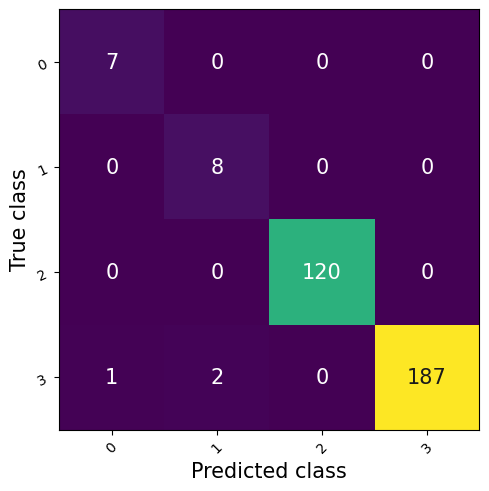

In [93]:
target_train = train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_train = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_train.update(preds_train, target_train)
fig_, ax_ = metric_train.plot()

In [94]:
metric_collection(preds_train, target_train)

{'MulticlassPrecision': tensor([0.8750, 0.8000, 1.0000, 1.0000], device='cuda:0'),
 'MulticlassRecall': tensor([1.0000, 1.0000, 1.0000, 0.9842], device='cuda:0'),
 'MulticlassF1Score': tensor([0.9333, 0.8889, 1.0000, 0.9920], device='cuda:0')}

### 4-2. Evaluating model with Test Dataset

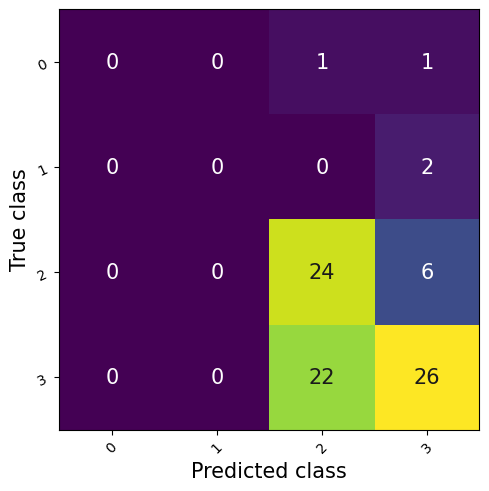

In [95]:
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_test = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_test.update(preds_test, target_test)
fig_, ax_ = metric_test.plot()

In [96]:
metric_collection(preds_test, target_test)

{'MulticlassPrecision': tensor([0.0000, 0.0000, 0.5106, 0.7429], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.8000, 0.5417], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.6234, 0.6265], device='cuda:0')}

## 5. Save model

In [30]:
# 단일 GPU에서 훈련시킨 경우
file_name = "./Model_save/feature3201157_Adam0001s99_ep30_D8_F0_nl3_dr1_new.pt"
T.save(net.state_dict(), file_name)  
print("\ntrained model state saved")


trained model state saved


In [97]:
# 여러 GPU에서 DataParallel로 훈련시키고 나서 weight를 통합해서 저장하는 방법 
# (나중에 불러낸 후 단일 GPU에서 추론 해야만 할 때를 대비하기 위함임) 
file_name = "./Model_save/feature1501_Adam0001s99_ep23_D8_F0_nl3_dr1_new_multi.pt"
T.save(net.module.state_dict(), file_name)  
print("\ntrained model state saved")


trained model state saved


In [16]:
# load saved model
net = Transformer_Classifier().to(device)
net.load_state_dict(T.load('./Model_save/feature3201157_Adam00001s99_ep31_D8_F0_dr1.pt'))

<All keys matched successfully>

## 6. Visualize the latent space of networks using UMAP

In [229]:
X_Train, X_Train.shape

(array([[206.81746899, 172.09803197, 195.58499015, ...,   0.        ,
         148.0143489 ,   0.        ],
        [192.49203866, 124.22168367, 183.73903337, ...,   0.        ,
         135.35931518,  90.02817139],
        [202.60430677, 174.38158934, 199.61163048, ...,   0.        ,
         168.82660949,   0.        ],
        ...,
        [209.13745666, 221.49519109, 193.80739957, ...,   0.        ,
         174.96269951,   0.        ],
        [212.35138939, 167.71319769, 194.39923904, ...,   0.        ,
         149.86767685,   0.        ],
        [212.06941073, 195.78703724, 195.65101134, ..., 148.34805441,
         154.3602092 ,  92.91253894]]),
 (325, 1501))

### 6-1. Analyzing Training dataset

In [230]:
mapper = umap.UMAP().fit(X_Train)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Axes: >

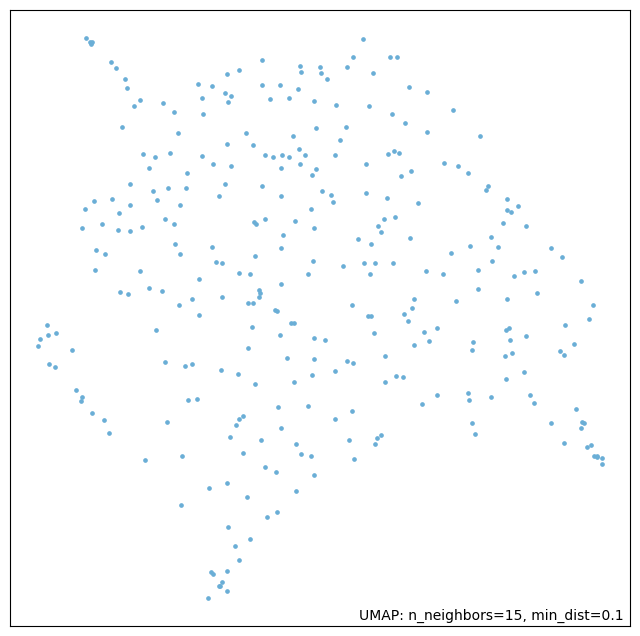

In [231]:
umap.plot.points(mapper)

In [232]:
Y_Train, Y_Train.shape

(array([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

<Axes: >

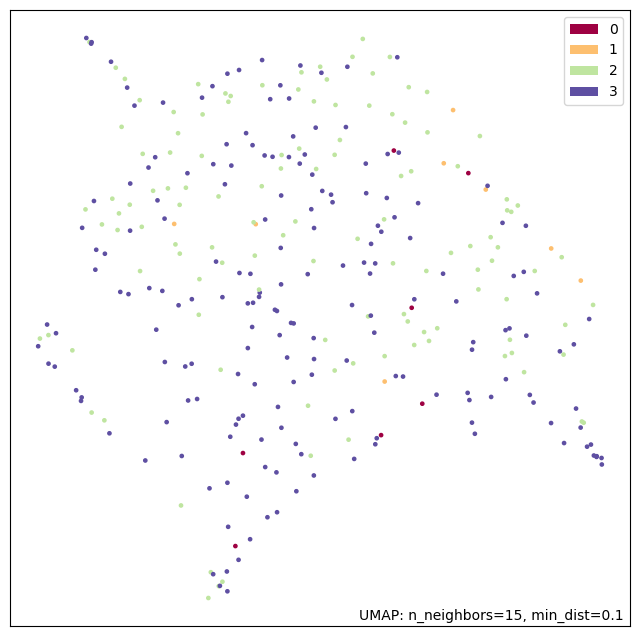

In [233]:
umap.plot.points(mapper, labels=Y_Train)#, theme='darkgreen')
# umap.plot.points(mapper, labels=Y_Train, color_key_cmap='Paired', background='black')

In [234]:
hover_data = pd.DataFrame({'index':np.arange(325),
                           'label':Y_Train})
hover_data['item'] = hover_data.label.map(
    {
        0:'GX',
        1:'G1',
        2:'G2',
        3:'G3',
    }
)
umap.plot.output_notebook()

Loading BokehJS ...

In [235]:
p = umap.plot.interactive(mapper, labels=Y_Train, hover_data=hover_data, point_size=3)
umap.plot.show(p)

invalid value encountered in divide


<Axes: >

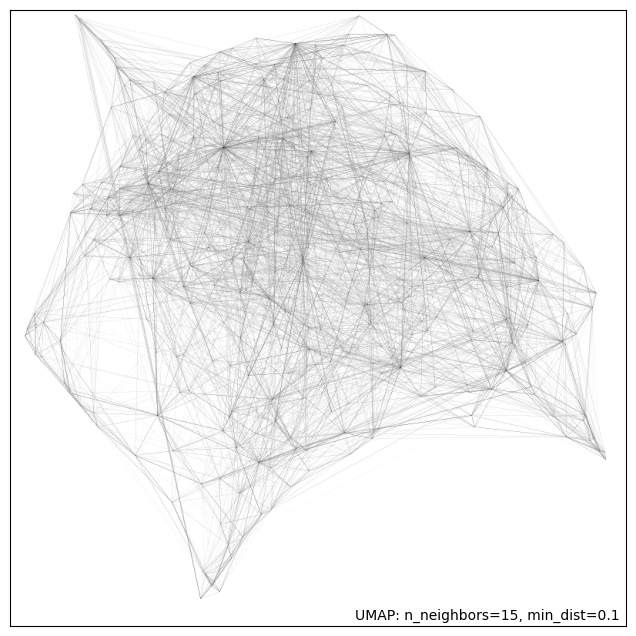

In [236]:
umap.plot.connectivity(mapper, show_points=True)

Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!


<Axes: >

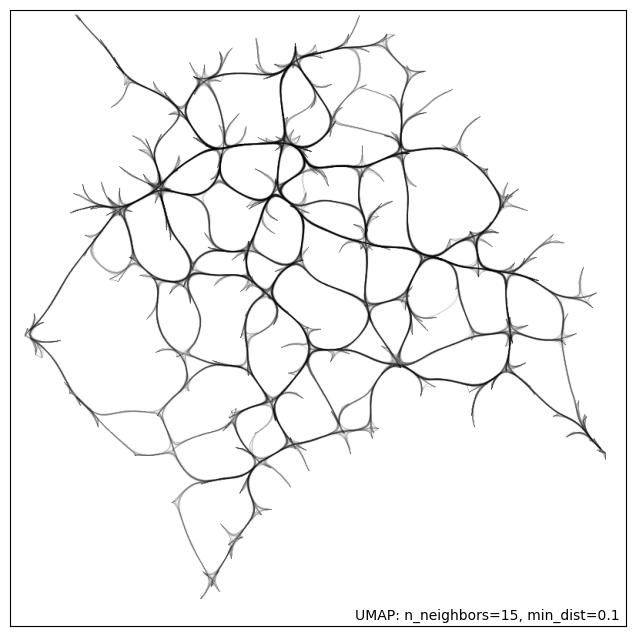

In [237]:
umap.plot.connectivity(mapper, edge_bundling='hammer')

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

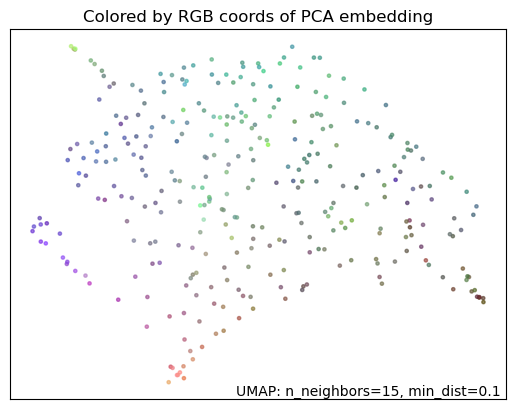

In [238]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


<Axes: title={'center': 'Colored by RGB coords of Vector Quantization'}>

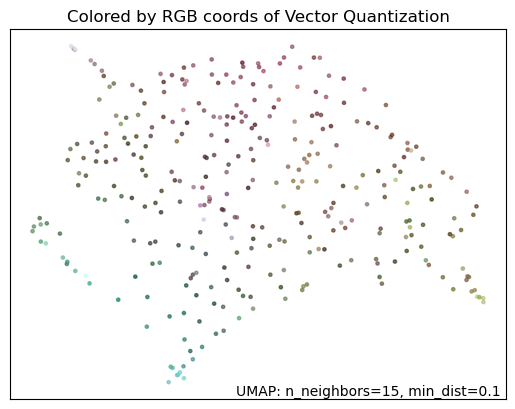

In [239]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')

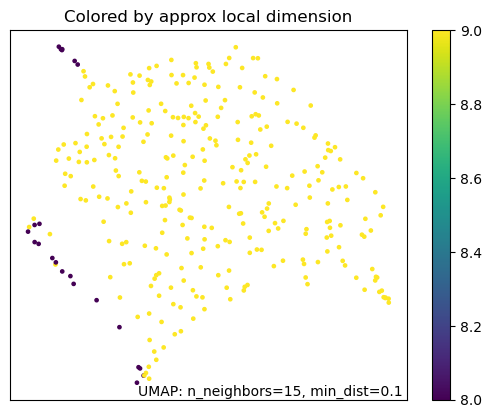

In [240]:
local_dims = umap.plot.diagnostic(mapper, diagnostic_type='local_dim')
# umap.plot.diagnostic(mapper, diagnostic_type='neighborhood')

### 6-2. Compute output of layers of network

In [11]:
# import gc
# net.cpu()
# del net 
# net2.cpu()
# del net2
# gc.collect()
# T.cuda.empty_cache()

##### GPU 1번에는 훈련 안 된 모델, GPU 2번에는 훈련 된 모델 불러오기

In [11]:
net = Transformer_Classifier().to(device)
net.eval()
# load saved model
net2 = Transformer_Classifier().to(device2)
net2.load_state_dict(T.load('./Model_save/feature1501_Adam0001s99_ep23_D8_F0_nl3_dr1_new_multi.pt'))               
net2.eval()

Transformer_Classifier(
  (embed): Embedding(320, 8)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
    )
    (linear1): Linear(in_features=8, out_features=8, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=8, out_features=8, bias=True)
    (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (trans_enc): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_fe

##### 양쪽 모델에 Train 데이터 넣고 forward 한 다음 각 층을 빼서 numpy로 변환

In [243]:
# 훈련 안 된 모델에 train 데이터 넣어서 forward 
embedded = net.embed(train_ds.x_data.int())  
z = embedded.reshape(-1, I, D)  
pos_embedded = net.pos_enc(z) 
t_encoded = net.trans_enc(pos_embedded) 
z = t_encoded.reshape(-1, D*I)  
fc3_output = net.fc3(z)
embedded.shape, pos_embedded.shape, t_encoded.shape, fc3_output.shape

(torch.Size([325, 1501, 8]),
 torch.Size([325, 1501, 8]),
 torch.Size([325, 1501, 8]),
 torch.Size([325, 4]))

In [244]:
# 훈련 된 모델에 train 데이터 넣어서 forward 
embedded2 = net2.embed(train_ds2.x_data.int())  
z = embedded2.reshape(-1, I, D)  
pos_embedded2 = net2.pos_enc(z) 
t_encoded2 = net2.trans_enc(pos_embedded2) 
z = t_encoded2.reshape(-1, D*I)  
fc3_output2 = net2.fc3(z)
embedded2.shape, pos_embedded2.shape, t_encoded2.shape, fc3_output2.shape

(torch.Size([325, 1501, 8]),
 torch.Size([325, 1501, 8]),
 torch.Size([325, 1501, 8]),
 torch.Size([325, 4]))

In [245]:
# Train 데이터로 추론한 모델 각 층의 numpy 데이터
n_sample = 325 
embedded_before = embedded.detach().cpu().numpy().reshape(n_sample, -1)
embedded_after = embedded2.detach().cpu().numpy().reshape(n_sample, -1)
pos_embedded_before = pos_embedded.detach().cpu().numpy().reshape(n_sample, -1)
pos_embedded_after = pos_embedded2.detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_before = t_encoded.detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_after = t_encoded2.detach().cpu().numpy().reshape(n_sample, -1)
fc3_output_before = fc3_output.detach().cpu().numpy()
fc3_output_after = fc3_output2.detach().cpu().numpy()
embedded_after.shape, pos_embedded_after.shape, t_encoded_after.shape, fc3_output_after.shape

((325, 12008), (325, 12008), (325, 12008), (325, 4))

##### 양쪽 모델에 Test 데이터 넣고 forward 한 다음 각 층을 빼서 numpy로 변환

In [12]:
# 훈련 안 된 모델에 test 데이터 넣어서 forward 
embedded = net.embed(test_ds.x_data.int())  
z = embedded.reshape(-1, I, D)  
pos_embedded = net.pos_enc(z) 
t_encoded = net.trans_enc(pos_embedded) 
z = t_encoded.reshape(-1, D*I)  
fc3_output = net.fc3(z)
embedded.shape, pos_embedded.shape, t_encoded.shape, fc3_output.shape

(torch.Size([82, 1501, 8]),
 torch.Size([82, 1501, 8]),
 torch.Size([82, 1501, 8]),
 torch.Size([82, 4]))

In [13]:
# 훈련 된 모델에 test 데이터 넣어서 forward 
embedded2 = net2.embed(test_ds2.x_data.int())  
z = embedded2.reshape(-1, I, D)  
pos_embedded2 = net2.pos_enc(z) 
t_encoded2 = net2.trans_enc(pos_embedded2) 
z = t_encoded2.reshape(-1, D*I)  
fc3_output2 = net2.fc3(z)
embedded2.shape, pos_embedded2.shape, t_encoded2.shape, fc3_output2.shape

(torch.Size([82, 1501, 8]),
 torch.Size([82, 1501, 8]),
 torch.Size([82, 1501, 8]),
 torch.Size([82, 4]))

In [14]:
# Test 데이터로 추론한 모델 각 층의 numpy 데이터
n_sample = 82
embedded_before = embedded[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
embedded_after = embedded2[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
pos_embedded_before = pos_embedded[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
pos_embedded_after = pos_embedded2[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_before = t_encoded[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_after = t_encoded2[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
fc3_output_before = fc3_output.detach().cpu().numpy()
fc3_output_after = fc3_output2.detach().cpu().numpy()
embedded_after.shape, pos_embedded_after.shape, t_encoded_after.shape, fc3_output_after.shape

((82, 1501), (82, 1501), (82, 1501), (82, 4))

### 6-3. Visualizing network

In [15]:
embedded_mapper_before = umap.UMAP().fit(embedded_before)
embedded_mapper_after = umap.UMAP().fit(embedded_after)

Uembedding_embedded_before = embedded_mapper_before.transform(embedded_before)
Uembedding_embedded_after = embedded_mapper_after.transform(embedded_after)

In [16]:
pos_embedded_mapper_before = umap.UMAP().fit(pos_embedded_before)
pos_embedded_mapper_after = umap.UMAP().fit(pos_embedded_after)

Uembedding_pos_embedded_before = pos_embedded_mapper_before.transform(pos_embedded_before)
Uembedding_pos_embedded_after = pos_embedded_mapper_after.transform(pos_embedded_after)

In [17]:
t_encoded_mapper_before = umap.UMAP().fit(t_encoded_before)
t_encoded_mapper_after = umap.UMAP().fit(t_encoded_after)

Uembedding_t_encoded_before = t_encoded_mapper_before.transform(t_encoded_before)
Uembedding_t_encoded_after = t_encoded_mapper_after.transform(t_encoded_after)

In [18]:
fc3_output_mapper_before = umap.UMAP().fit(fc3_output_before)
fc3_output_mapper_after = umap.UMAP().fit(fc3_output_after)

Uembedding_fc3_output_before = fc3_output_mapper_before.transform(fc3_output_before)
Uembedding_fc3_output_after = fc3_output_mapper_after.transform(fc3_output_after)

#### 6-3-1. Embdding layer before & after training

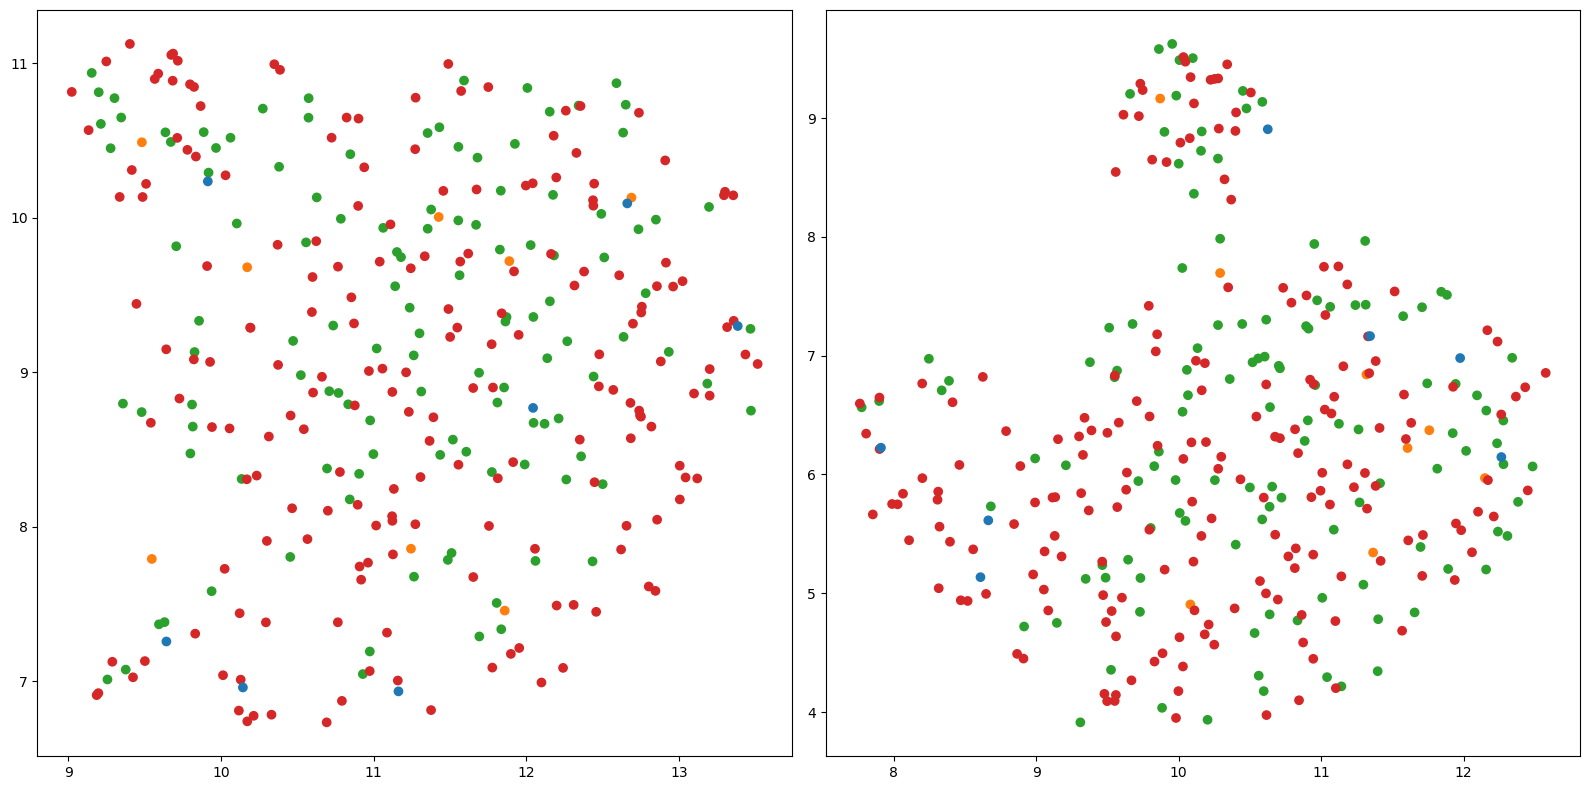

In [250]:
# Train set 으로
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_embedded_before[:, 0], Uembedding_embedded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_embedded_after[:, 0], Uembedding_embedded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

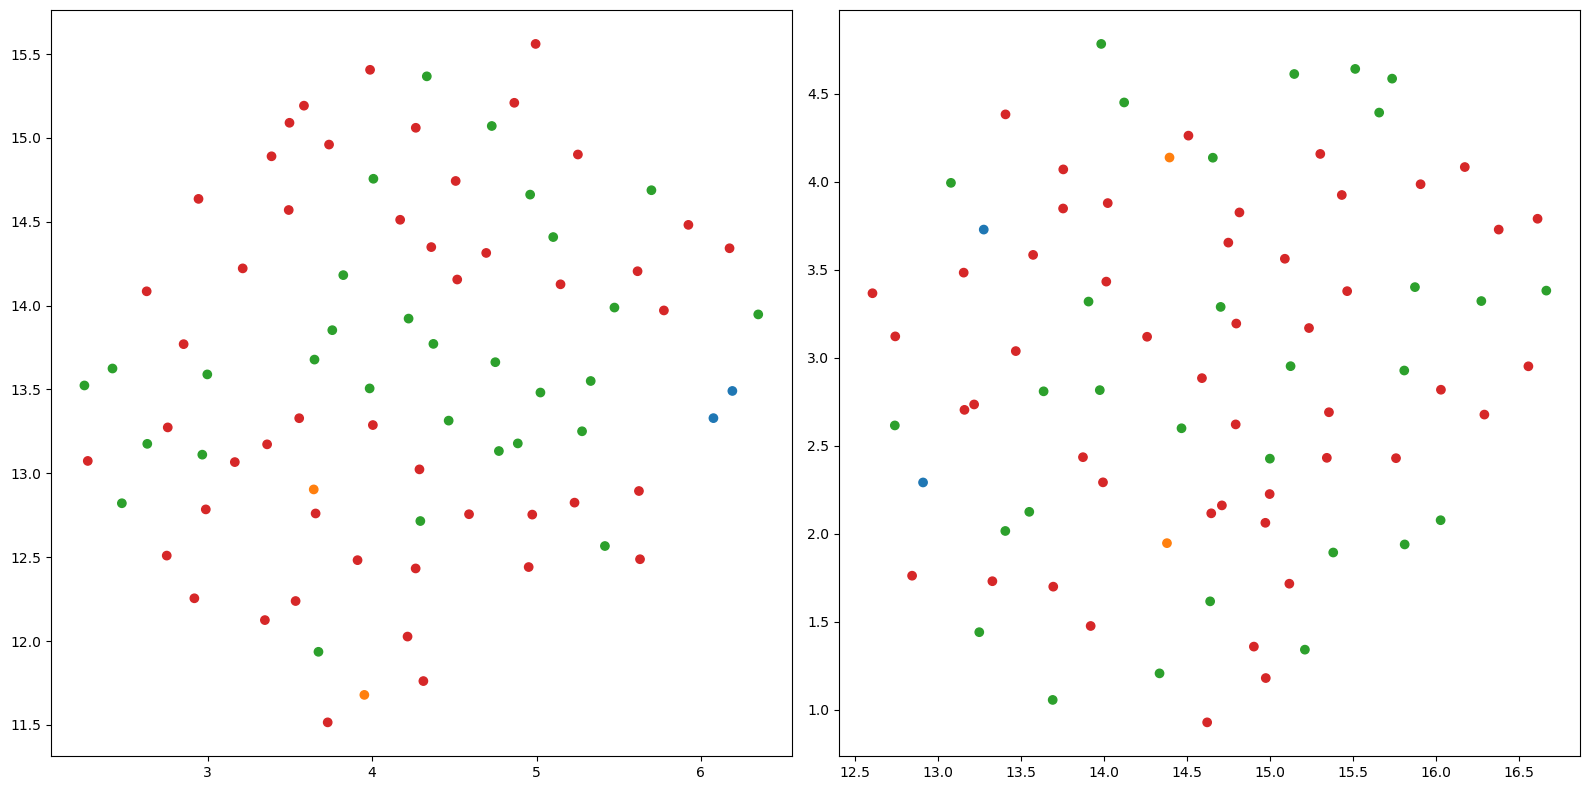

In [19]:
# Test set 으로
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_embedded_before[:, 0], Uembedding_embedded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
axes[1].scatter(Uembedding_embedded_after[:, 0], Uembedding_embedded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
plt.tight_layout()
plt.show()
plt.close(fig)

#### 6-3-2. Positional Embdding layer before & after training

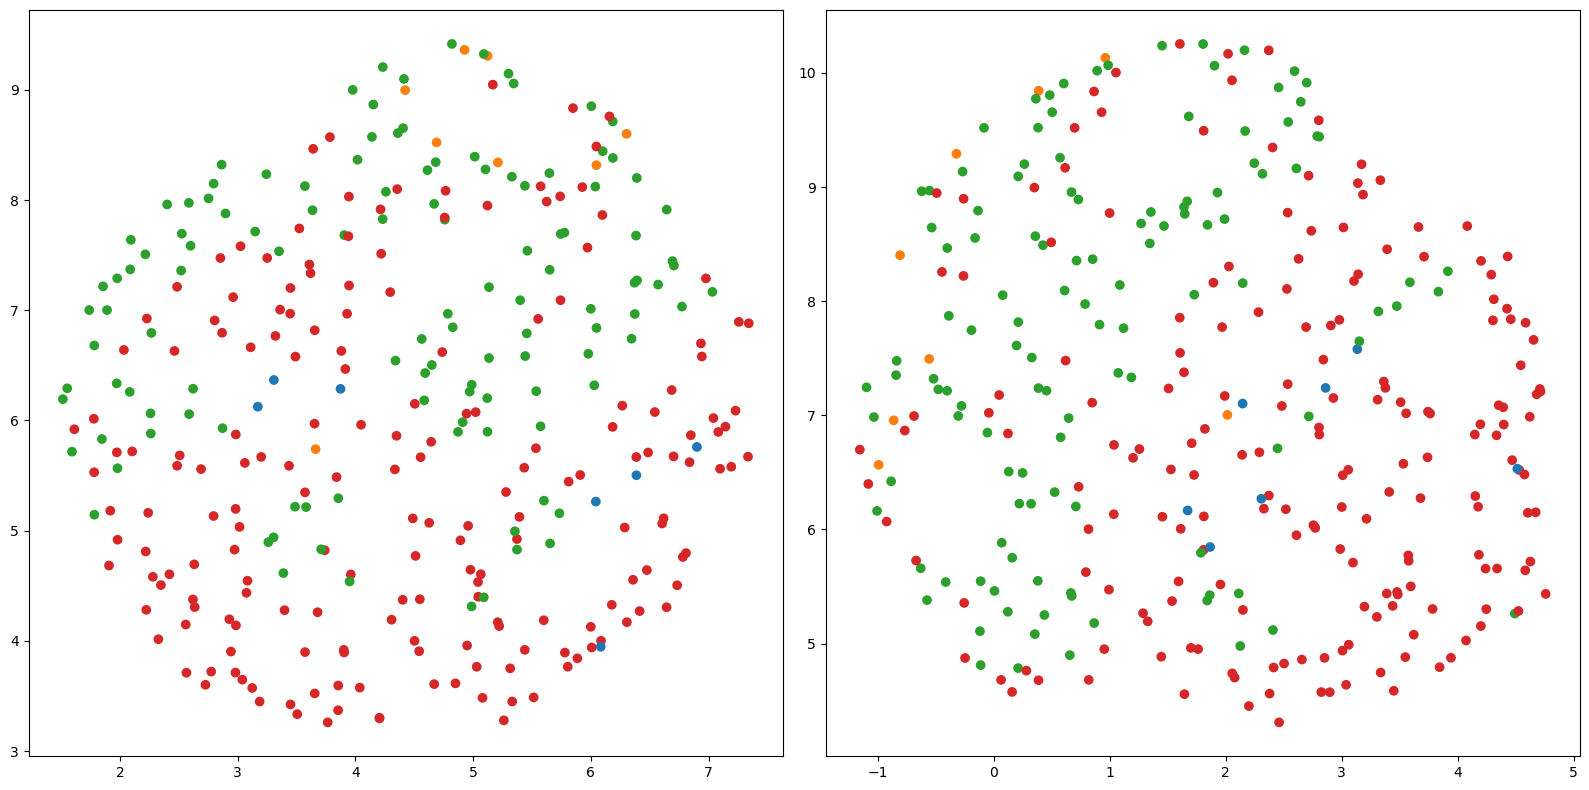

In [251]:
# Train set 으로
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_pos_embedded_before[:, 0], Uembedding_pos_embedded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_pos_embedded_after[:, 0], Uembedding_pos_embedded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

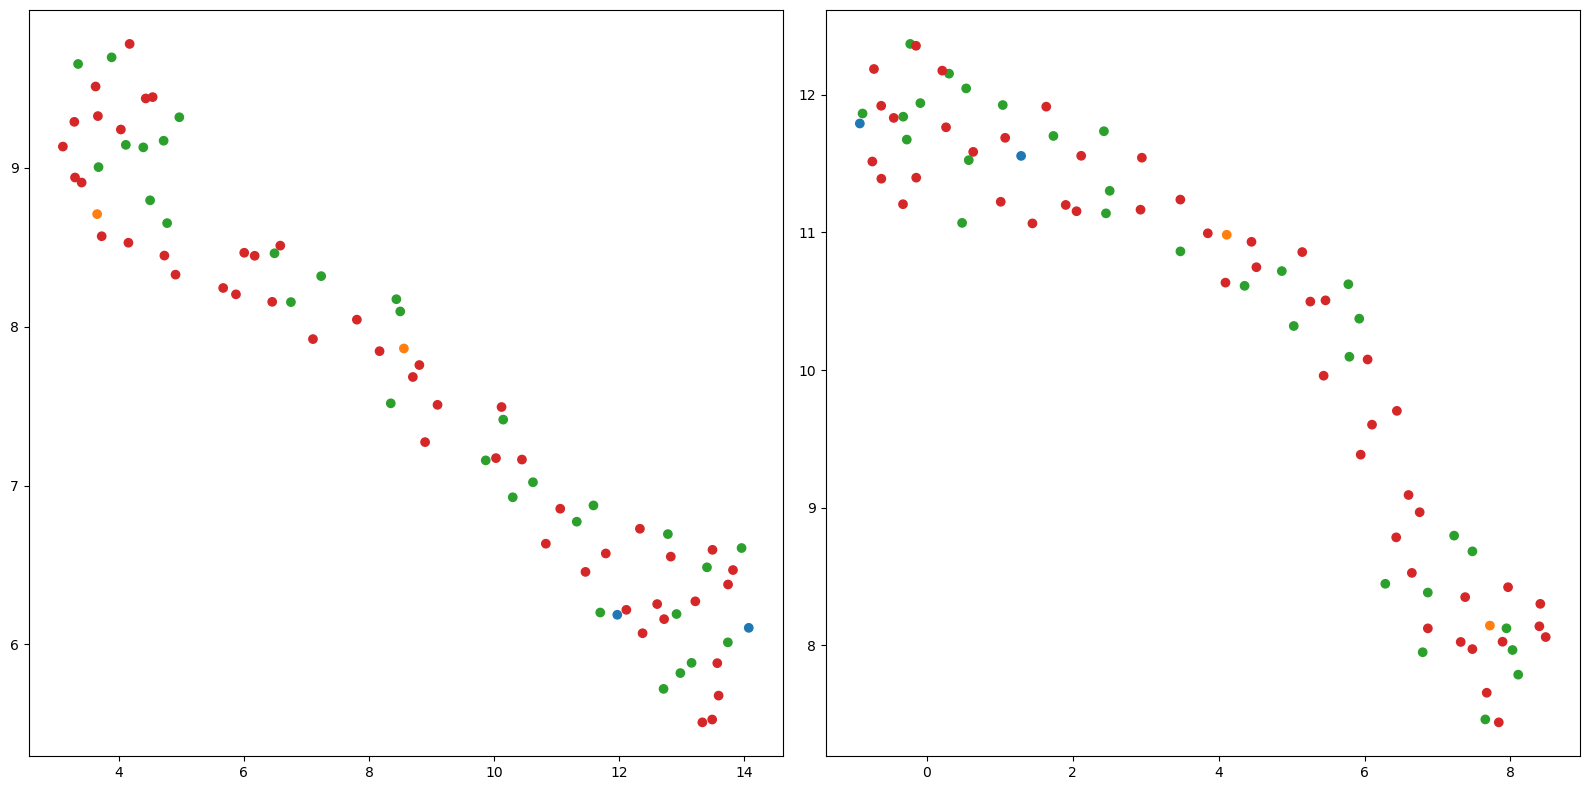

In [20]:
# Test set 으로
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_pos_embedded_before[:, 0], Uembedding_pos_embedded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
axes[1].scatter(Uembedding_pos_embedded_after[:, 0], Uembedding_pos_embedded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
plt.tight_layout()
plt.show()
plt.close(fig)

#### 6-3-3. Transformer Encoder before & after training

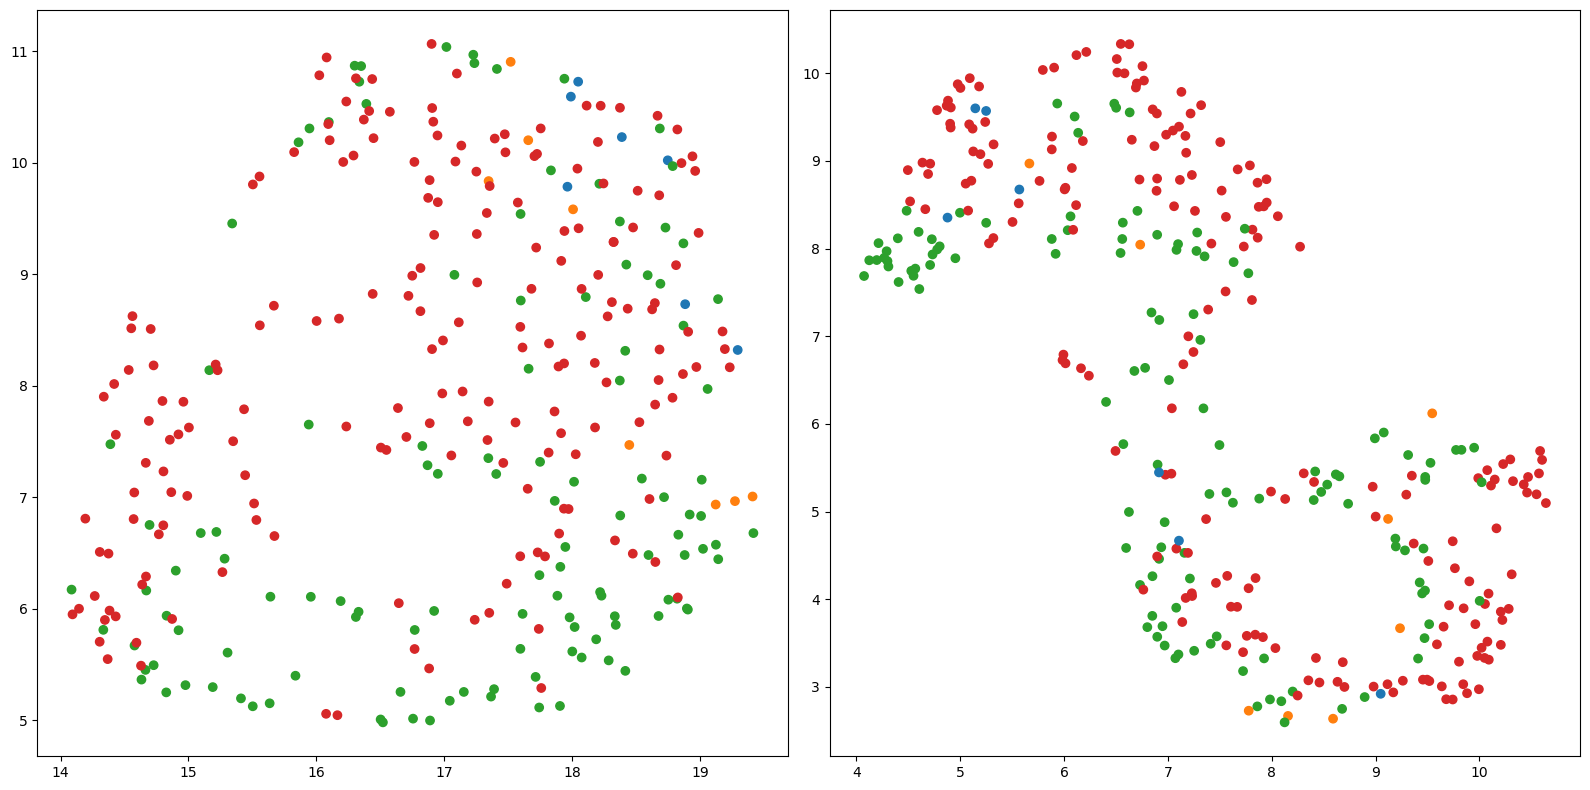

In [252]:
# Train Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_t_encoded_before[:, 0], Uembedding_t_encoded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_t_encoded_after[:, 0], Uembedding_t_encoded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

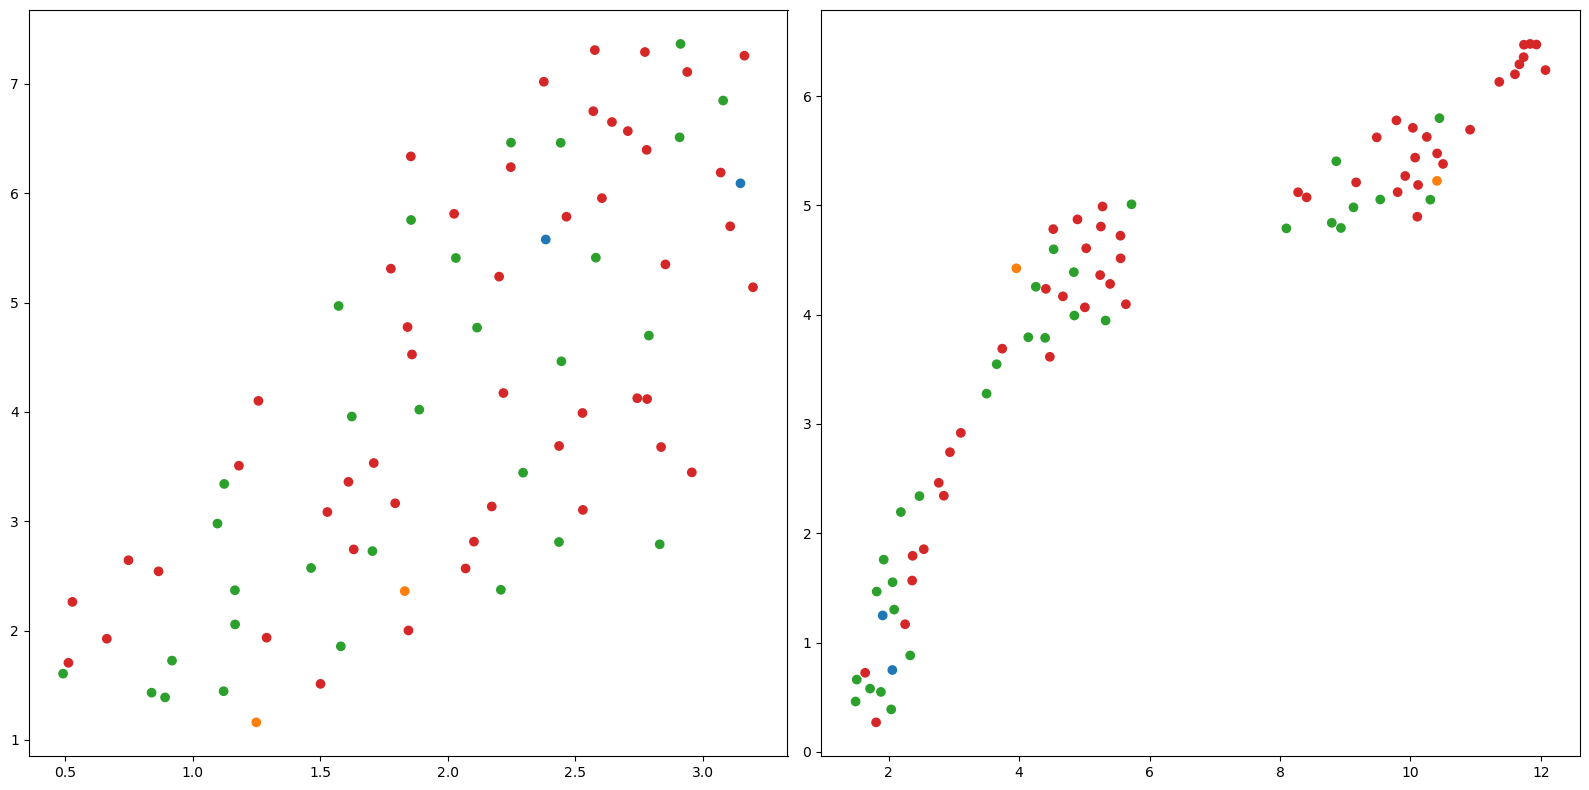

In [21]:
# Test Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_t_encoded_before[:, 0], Uembedding_t_encoded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
axes[1].scatter(Uembedding_t_encoded_after[:, 0], Uembedding_t_encoded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
plt.tight_layout()
plt.show()
plt.close(fig)

#### 6-3-4. Fully-Connected Layer1 before & after training

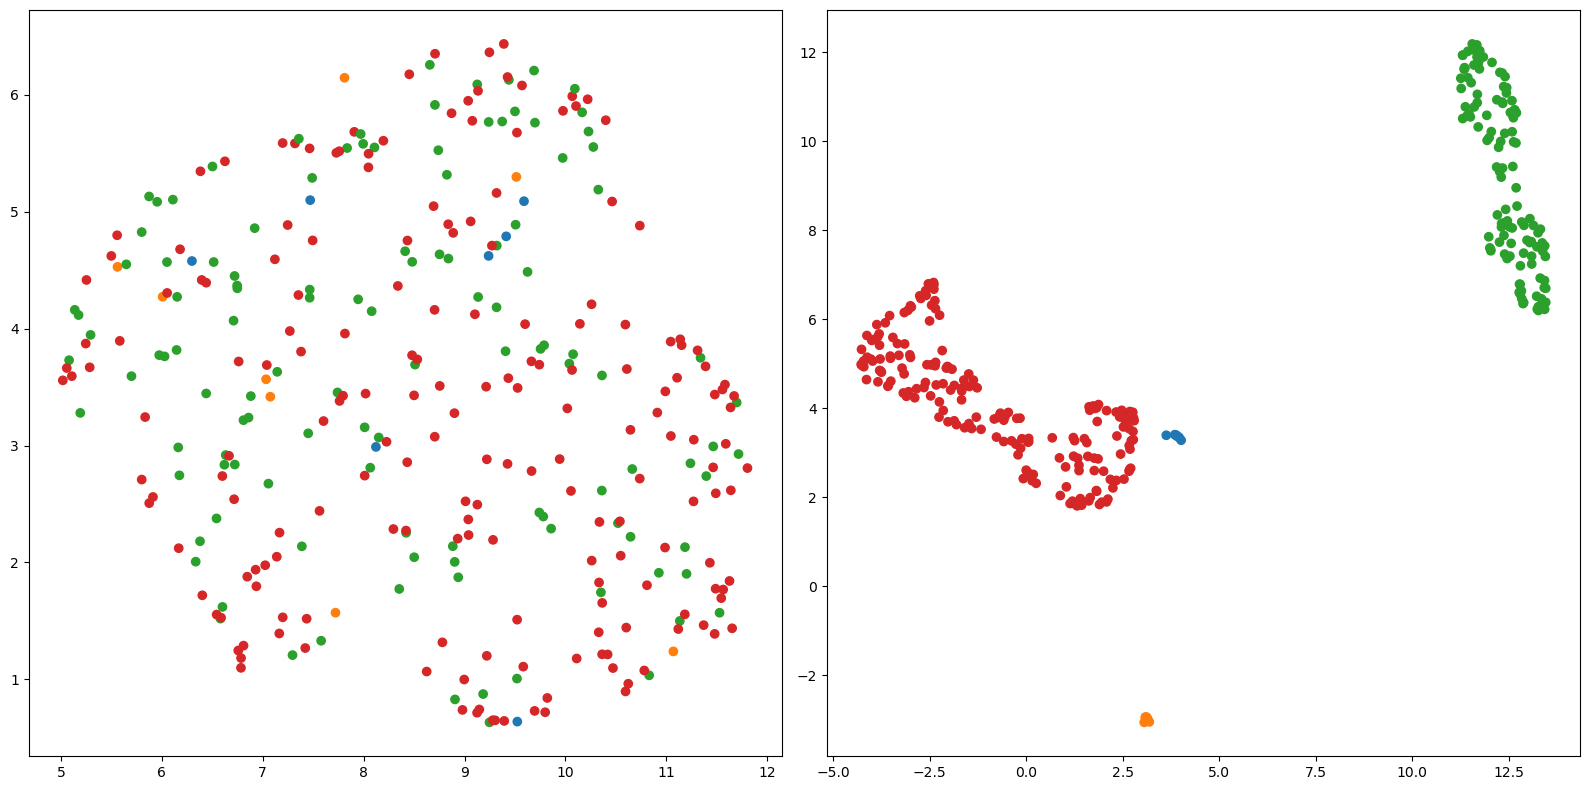

In [253]:
# Train Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_fc3_output_before[:, 0], Uembedding_fc3_output_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_fc3_output_after[:, 0], Uembedding_fc3_output_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

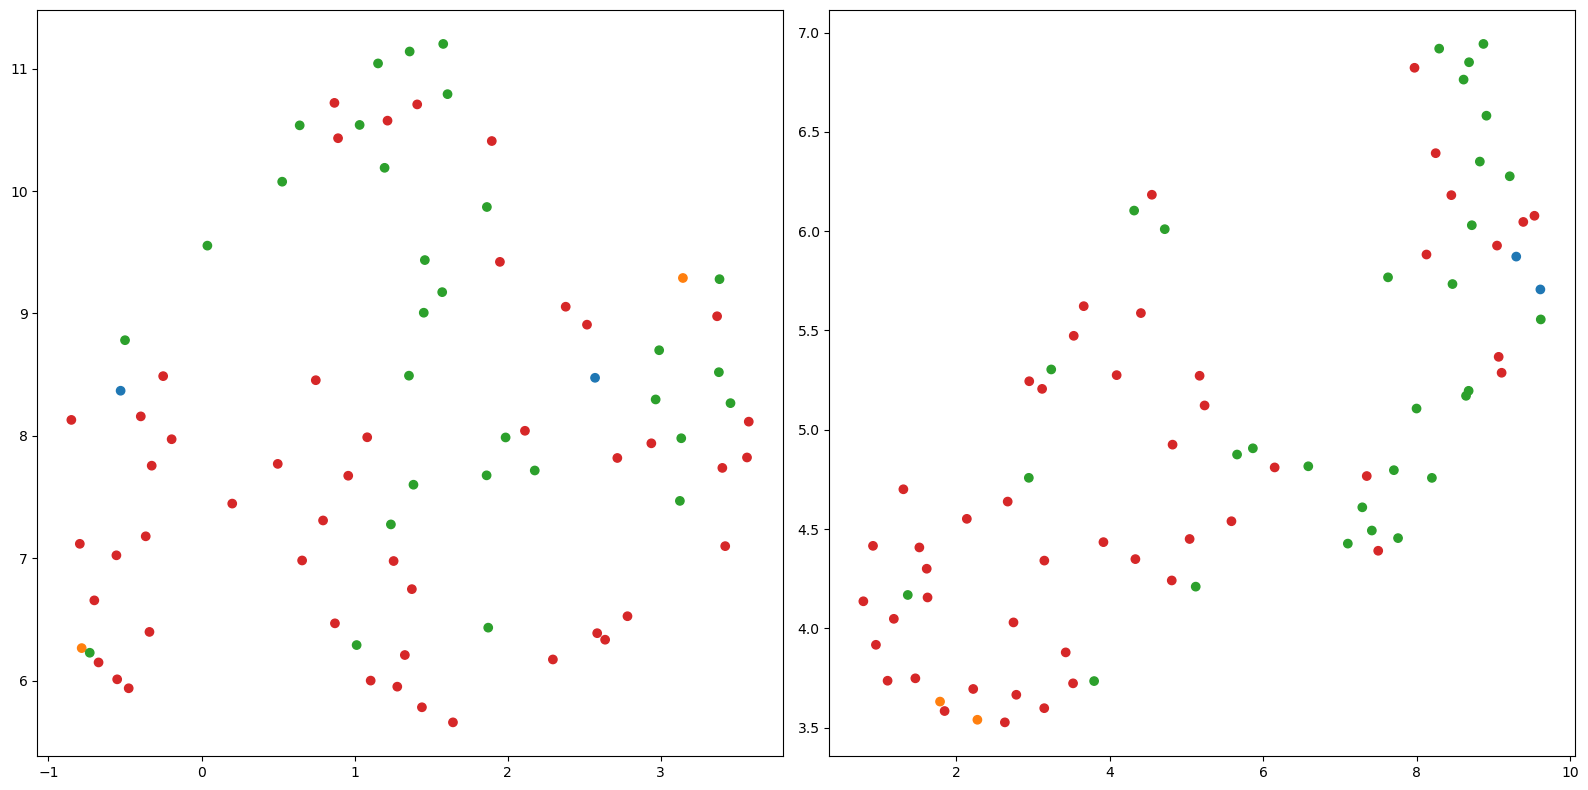

In [22]:
# Test Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_fc3_output_before[:, 0], Uembedding_fc3_output_before[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
axes[1].scatter(Uembedding_fc3_output_after[:, 0], Uembedding_fc3_output_after[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
plt.tight_layout()
plt.show()
plt.close(fig)

In [254]:
# FC2 Layer 들어가기 전의 데이터에서 세부사항 확인해 보기 
# (index가 나오므로 이것으로 어느 유전자인지 역추적 가능할 것임)
hover_data = pd.DataFrame({'index':np.arange(325),
                           'label':Y_Train})
hover_data['item'] = hover_data.label.map(
    {
        0:'GX',
        1:'G1',
        2:'G2',
        3:'G3',
    }
)
umap.plot.output_notebook()
p = umap.plot.interactive(fc3_output_mapper_after, labels=Y_Train, hover_data=hover_data, point_size=4)
umap.plot.show(p)

Loading BokehJS ...

## 7. Analizing the degree of contribution of each feature using SHAP

In [11]:
# np.set_printoptions(threshold=np.inf, linewidth=90)
# np.set_printoptions(threshold=1000, linewidth=90)
# np.seterr(divide='warn', invalid='warn')

#### 7-0. 트랜스포머 인코더 feature 번호가 어떤 유전자ID였는지 참조할 리스트 만들기

In [ ]:
df = pd.read_pickle('xy_STAD-related-only3.pkl')
df

,submitter_id.samples,neoplasm_histologic_grade,ENSG00000245105.2,ENSG00000131043.10,ENSG00000085563.13,ENSG00000103222.17,ENSG00000023839.9,ENSG00000108846.14,ENSG00000091262.13,ENSG00000118777.9,...,ENSG00000177410.11,ENSG00000140836.13,ENSG00000253661.1,ENSG00000166432.13,ENSG00000163848.17,ENSG00000056277.14,ENSG00000167962.11,ENSG00000180357.8,ENSG00000183779.6,ENSG00000019995.6
0,TCGA-3M-AB46-01A,G2,12.631540,18.312495,14.318532,16.364047,11.037089,18.659929,15.430360,13.646748,...,21.045336,16.180944,11.412951,13.115407,17.260566,15.524566,17.837062,15.338686,19.374794,15.734897
1,TCGA-3M-AB47-01A,G3,12.959527,17.934268,16.160946,18.282712,11.768339,16.547711,15.367687,16.074496,...,19.789973,16.952844,12.891470,14.712015,16.866016,15.622206,18.062104,16.553608,21.262279,15.886567
2,TCGA-B7-5818-01A,G3,9.805638,18.645617,12.880046,18.169850,7.718481,19.585772,11.018773,10.981525,...,19.983948,16.317194,8.185707,10.143445,17.138078,15.401180,18.617195,17.257773,18.325260,15.495983
3,TCGA-B7-A5TI-01A,G3,13.179467,18.243948,15.407460,18.950430,15.200596,20.725672,16.640060,13.642704,...,19.624785,15.496281,9.534131,11.914558,16.778476,14.715512,18.427179,17.038676,18.098576,15.567411
4,TCGA-B7-A5TJ-01A,G1,13.172761,18.771969,14.176191,18.124846,14.429294,19.441774,15.288600,13.754549,...,20.980256,17.172219,9.862818,11.560136,17.101747,14.773824,19.187604,16.485147,21.817616,15.463538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,TCGA-VQ-AA6G-01A,G2,11.189674,17.880143,13.535621,17.766386,10.952426,19.858542,15.618313,13.916546,...,18.220067,16.016099,0.000000,11.106274,17.097017,14.255276,18.389971,17.379477,19.943897,15.953224
403,TCGA-VQ-AA6J-01A,G3,13.843641,18.303575,14.388388,18.411861,15.848974,19.732003,15.591814,16.345803,...,19.652691,16.994635,8.609251,15.553067,17.214653,15.752475,18.069899,16.968723,20.527869,15.465501
404,TCGA-VQ-AA6K-01A,G3,13.195385,18.808490,15.105125,18.414490,17.505974,19.725012,15.973455,14.169108,...,19.427959,16.877440,10.742717,14.342780,17.279563,14.780608,18.611692,17.048796,20.313476,15.819704
405,TCGA-ZA-A8F6-01A,G2,14.989051,18.202771,18.111348,18.294249,13.809347,18.927904,15.845785,16.732377,...,19.494675,17.223242,11.699583,14.811041,16.962942,15.529613,17.571429,17.048029,20.722353,15.953487


In [18]:
gene_ids_trimmed = [gene_id[:15] for gene_id in df.columns[2:]]
for original, trimmed in zip(df.columns[2:], gene_ids_trimmed):
    df.rename(columns={original:trimmed}, inplace=True)
dfs = df.sort_index(axis=1)
dfs

,ENSG00000001036,ENSG00000001626,ENSG00000002330,ENSG00000003400,ENSG00000003402,ENSG00000005007,ENSG00000005156,ENSG00000005175,ENSG00000005194,ENSG00000005844,...,ENSG00000278910,ENSG00000280924,ENSG00000280997,ENSG00000281183,ENSG00000281189,ENSG00000281202,ENSG00000281406,ENSG00000281450,neoplasm_histologic_grade,submitter_id.samples
0,20.220979,14.665292,18.727956,18.054834,16.883271,17.875547,16.233214,17.925067,17.105839,14.004341,...,9.415178,13.167983,0.000000,13.485292,13.578557,0.000000,15.438352,8.090678,G2,TCGA-3M-AB46-01A
1,18.500387,18.794606,18.090443,17.441156,17.084666,18.313232,15.072061,16.966393,18.010680,16.427446,...,10.799621,11.281136,0.000000,14.944210,11.546818,0.000000,12.354517,8.889208,G3,TCGA-3M-AB47-01A
2,19.761280,19.947795,19.709574,16.382809,17.009260,18.794353,16.590639,16.450929,18.271574,17.263513,...,11.088938,14.599826,8.546172,12.620040,13.064786,0.000000,15.455768,9.762250,G3,TCGA-B7-5818-01A
3,19.181518,10.613326,18.942790,16.730176,17.504471,18.283692,15.722849,16.700315,18.246164,15.791234,...,10.703615,13.796031,7.579382,13.917905,11.974194,0.000000,16.328196,0.000000,G3,TCGA-B7-A5TI-01A
4,19.586652,17.520498,18.527097,16.876615,16.508963,18.872212,15.133784,17.002714,18.221248,14.314973,...,10.185077,12.604413,10.960521,14.445830,12.838448,9.294717,16.457270,0.000000,G1,TCGA-B7-A5TJ-01A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,18.996392,16.725651,17.717748,19.014720,17.760508,19.068443,16.721096,16.808091,18.048495,14.208590,...,8.973679,13.890051,7.433210,14.811144,12.551461,0.000000,15.849008,9.230485,G2,TCGA-VQ-AA6G-01A
403,18.794649,17.282670,17.603730,17.640446,17.107674,18.107977,16.429840,16.958818,18.187556,17.889670,...,10.099362,14.217296,8.969995,14.709362,13.369268,0.000000,15.227504,9.187872,G3,TCGA-VQ-AA6J-01A
404,19.295330,18.157491,17.706194,17.364764,17.483705,18.411735,16.221507,16.245028,18.307993,16.396496,...,11.649856,11.868503,10.104749,15.562842,12.255207,0.000000,17.192497,8.740135,G3,TCGA-VQ-AA6K-01A
405,18.647983,17.995544,18.393344,17.702167,17.343445,18.255709,15.532520,16.528308,17.310203,16.494008,...,10.215577,11.918873,0.000000,15.733577,12.591478,0.000000,14.480349,0.000000,G2,TCGA-ZA-A8F6-01A


In [19]:
STAD_related_geneID_list = dfs.columns[:-2]
STAD_related_geneID_list

Index(['ENSG00000001036', 'ENSG00000001626', 'ENSG00000002330',
       'ENSG00000003400', 'ENSG00000003402', 'ENSG00000005007',
       'ENSG00000005156', 'ENSG00000005175', 'ENSG00000005194',
       'ENSG00000005844',
       ...
       'ENSG00000278637', 'ENSG00000278705', 'ENSG00000278910',
       'ENSG00000280924', 'ENSG00000280997', 'ENSG00000281183',
       'ENSG00000281189', 'ENSG00000281202', 'ENSG00000281406',
       'ENSG00000281450'],
      dtype='object', length=1501)

##### 위 리스트의 gene ID에 상응하는 gene symbol 리스트 만들기

In [20]:
df = pd.read_excel('GASCplusPHGDH_1554.xlsx')
df

,Gene Symbol,Ensembl ID
0,A2M-AS1,ENSG00000245105
1,AAR2,ENSG00000131043
2,ABCB1,ENSG00000085563
3,ABCC1,ENSG00000103222
4,ABCC2,ENSG00000023839
...,...,...
1549,ZNF280C,ENSG00000056277
1550,ZNF598,ENSG00000167962
1551,ZNF609,ENSG00000180357
1552,ZNF703,ENSG00000183779


In [21]:
df['Gene Symbol']

0       A2M-AS1
1          AAR2
2         ABCB1
3         ABCC1
4         ABCC2
         ...   
1549    ZNF280C
1550     ZNF598
1551     ZNF609
1552     ZNF703
1553     ZRANB1
Name: Gene Symbol, Length: 1554, dtype: object

In [22]:
STAD_related_gene_symbol_list = []
for gene_ID in STAD_related_geneID_list:
    for i, E_ID in enumerate(df['Ensembl ID']):
        if gene_ID == E_ID:
            STAD_related_gene_symbol_list.append(df['Gene Symbol'][i])
len(STAD_related_gene_symbol_list)

1501

### 7-1. Deep Explainer

In [16]:
model = Transformer_Classifier().to(device)
model.load_state_dict(T.load('./Model_save/feature1501_Adam0001s99_ep23_D8_F0_nl3_dr1_new_multi.pt'))

<All keys matched successfully>

In [ ]:
background_data = T.cat((train_ds.x_data[:3], train_ds.x_data[10:50], train_ds.x_data[160:220], train_ds.x_data[398:401]), dim=0)
background_data.shape

torch.Size([103, 1501])

In [18]:
de = shap.DeepExplainer((model, model.trans_enc), background_data)

In [21]:
D_shap_values = de.shap_values(train_ds.x_data[110:115], check_additivity=False)

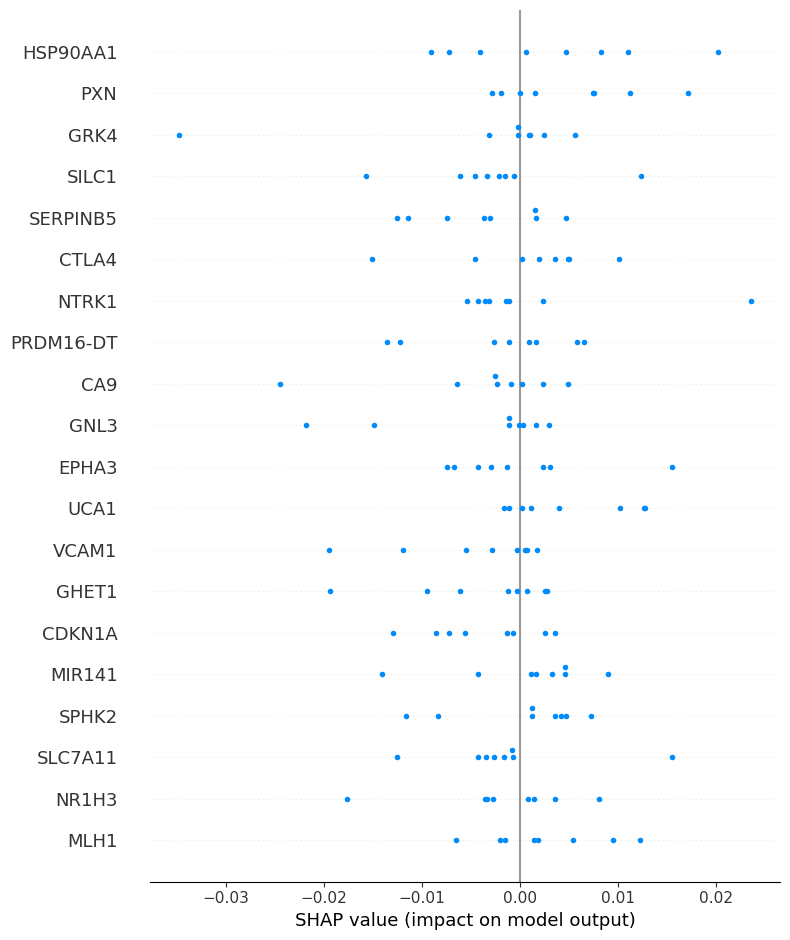

In [24]:
shap.summary_plot(D_shap_values[3][4].T, features=STAD_related_gene_symbol_list)

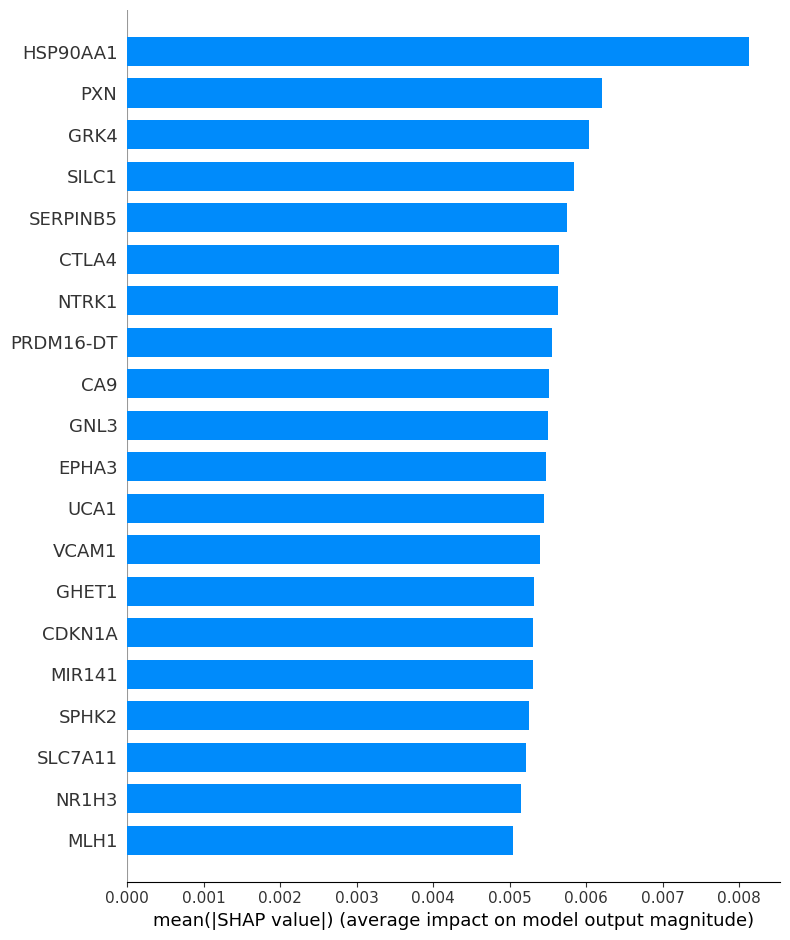

In [30]:
shap.summary_plot(D_shap_values[3][4].T, plot_type='bar', features=STAD_related_gene_symbol_list)

### 7-2. Gradient Explainer

In [10]:
model = Transformer_Classifier().to(device)
model.load_state_dict(T.load('./Model_save/feature1501_Adam0001s99_ep23_D8_F0_nl3_dr1_new_multi.pt'))

<All keys matched successfully>

In [17]:
# from torch.autograd import grad as original_grad

# def new_grad(*args, **kwargs):
#     kwargs['allow_unused'] = True

#     return original_grad(*args, **kwargs)

# T.autograd.grad = new_grad

In [11]:
train_ds.x_data.shape

torch.Size([325, 1501])

In [12]:
background_data = T.cat((train_ds.x_data[:270], train_ds.x_data[279:285]), dim=0)
background_data.shape

torch.Size([276, 1501])

In [13]:
# model.train()
ge = shap.GradientExplainer((model, model.trans_enc), background_data)

In [14]:
G_shap_values = ge.shap_values(train_ds.x_data[270:279])

In [15]:
np.sum(G_shap_values[3][0])

0.46060217707444595

In [29]:
len(G_shap_values), G_shap_values[3].shape, G_shap_values[3][2].shape, G_shap_values[3][2].T.shape

(4, (5, 1501, 8), (1501, 8), (8, 1501))

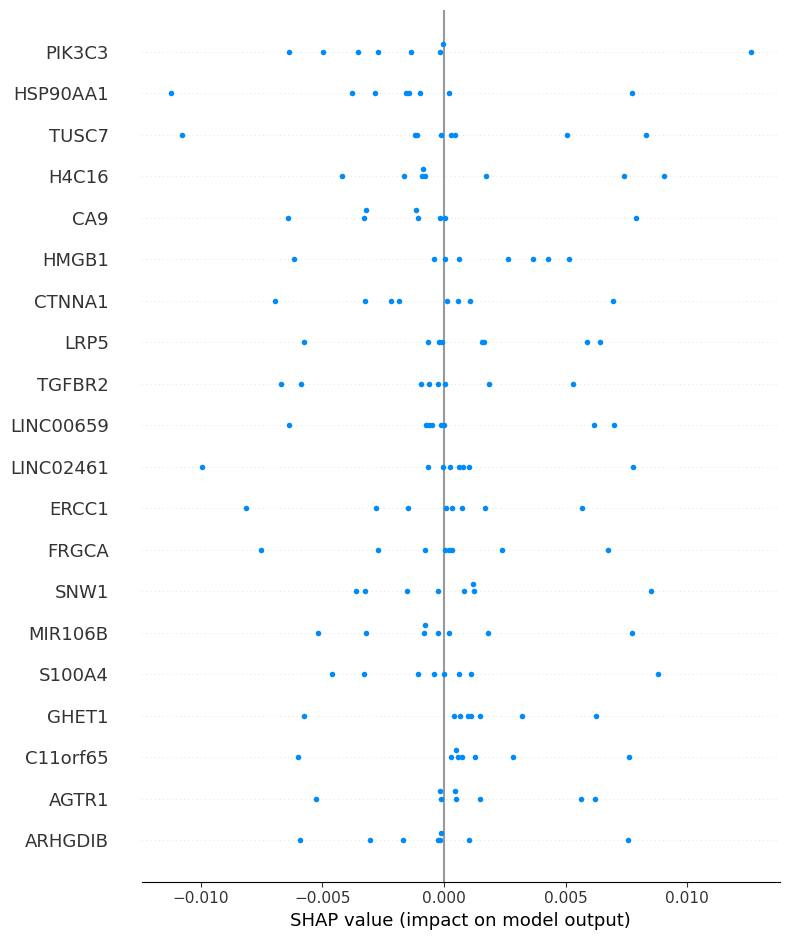

In [45]:
shap.summary_plot(G_shap_values[3][0].T, plot_type='dot', features=STAD_related_gene_symbol_list)

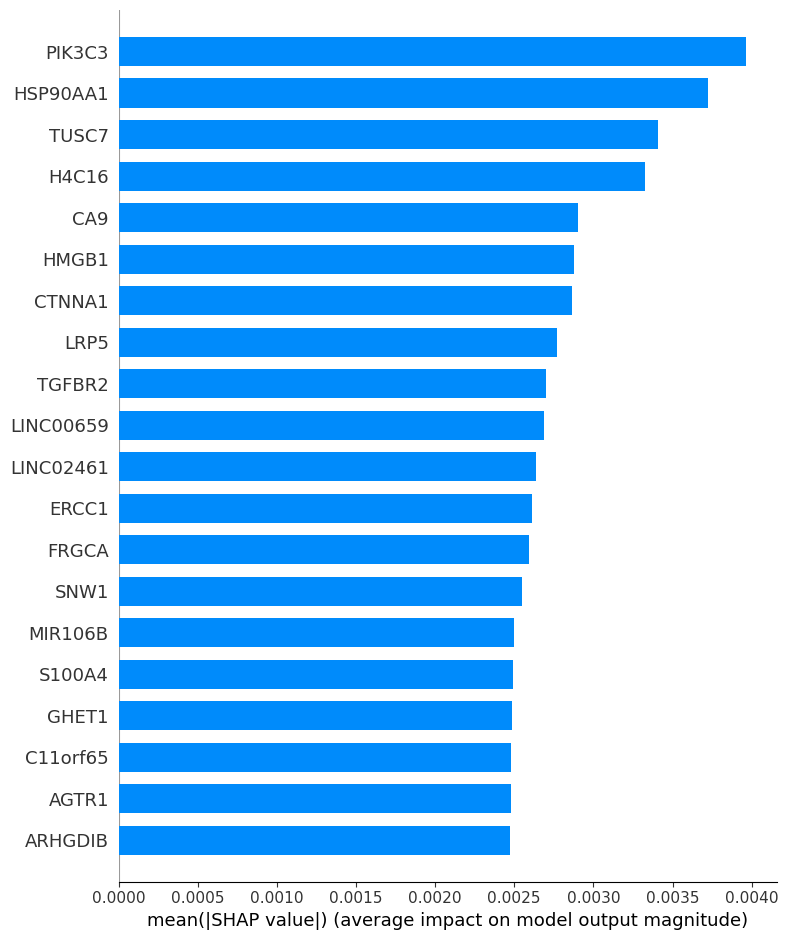

In [52]:
shap.summary_plot(G_shap_values[3][0].T, plot_type='bar', features=STAD_related_gene_symbol_list)

##### 7-3. 특정 샘플의 shap_value 를 CSV 파일로 만들기 

In [51]:
G_shap_values[3][4].T, G_shap_values[3][4].shape

(array([[ 5.73575902e-05, -2.29474460e-04,  2.57990897e-04, ...,
         -5.75908967e-04, -2.66836353e-04, -3.37311880e-04],
        [ 1.71523730e-03,  2.70122809e-06,  1.39262303e-03, ...,
          2.39071814e-03,  7.40630684e-04, -5.76333934e-03],
        [ 1.13204961e-03,  3.37155844e-04, -4.14663492e-04, ...,
          2.00371763e-04,  6.93824449e-04, -1.41650677e-03],
        ...,
        [-1.31043011e-04,  1.05715365e-03,  3.38377727e-04, ...,
          1.20831175e-03, -1.24131057e-03,  2.65299241e-03],
        [-2.01732180e-03,  3.45630127e-04, -8.20937219e-04, ...,
         -2.01738476e-04, -5.03640165e-04, -2.72290782e-04],
        [ 4.52195983e-04, -3.36434440e-03, -1.80017952e-03, ...,
          1.55006294e-03, -2.58302314e-03,  2.55867210e-03]]),
 (1501, 8))

In [33]:
G_df = pd.DataFrame(data=G_shap_values[3][0])
G_df

,0,1,2,3,4,5,6,7
0,0.000081,0.001701,0.000529,-0.004703,-0.000460,-0.000341,-0.001024,0.000460
1,-0.000077,0.000377,0.000127,0.002521,0.000630,0.000730,0.000412,-0.003122
2,-0.000225,0.001555,-0.000485,-0.002900,0.000201,0.000299,-0.000383,-0.001533
3,0.000291,-0.000754,0.000010,0.002706,0.000440,0.000235,0.000307,0.000746
4,0.000272,0.000605,-0.000790,-0.000389,-0.000077,0.001577,-0.001449,-0.003870
...,...,...,...,...,...,...,...,...
1496,0.000001,0.001498,0.000277,0.000764,-0.000443,0.001851,0.000092,-0.002382
1497,0.000410,0.003192,0.000991,0.006271,0.000650,0.001477,0.001113,-0.005757
1498,0.000043,0.001912,-0.000862,-0.000294,-0.000175,0.000695,0.000182,0.002302
1499,0.000048,0.000530,0.000625,-0.003153,-0.000225,-0.000900,-0.001263,-0.002639


In [34]:
G_shap_values[3][0][0][1]

0.0017010829991954035

In [54]:
len(STAD_related_gene_symbol_list)

1501

In [35]:
gene1501_df = pd.DataFrame(data=STAD_related_gene_symbol_list)
gene1501_df

,0
0,FUCA2
1,CFTR
2,BAD
3,CASP10
4,CFLAR
...,...
1496,NPTN-IT1
1497,GHET1
1498,LINC01097
1499,BLACAT1


In [36]:
G_gene1501_df = pd.concat([gene1501_df, G_df], axis=1)
G_gene1501_df

,0,0,1,2,3,4,5,6,7
0,FUCA2,0.000081,0.001701,0.000529,-0.004703,-0.000460,-0.000341,-0.001024,0.000460
1,CFTR,-0.000077,0.000377,0.000127,0.002521,0.000630,0.000730,0.000412,-0.003122
2,BAD,-0.000225,0.001555,-0.000485,-0.002900,0.000201,0.000299,-0.000383,-0.001533
3,CASP10,0.000291,-0.000754,0.000010,0.002706,0.000440,0.000235,0.000307,0.000746
4,CFLAR,0.000272,0.000605,-0.000790,-0.000389,-0.000077,0.001577,-0.001449,-0.003870
...,...,...,...,...,...,...,...,...,...
1496,NPTN-IT1,0.000001,0.001498,0.000277,0.000764,-0.000443,0.001851,0.000092,-0.002382
1497,GHET1,0.000410,0.003192,0.000991,0.006271,0.000650,0.001477,0.001113,-0.005757
1498,LINC01097,0.000043,0.001912,-0.000862,-0.000294,-0.000175,0.000695,0.000182,0.002302
1499,BLACAT1,0.000048,0.000530,0.000625,-0.003153,-0.000225,-0.000900,-0.001263,-0.002639


In [37]:
np.mean(np.abs(G_shap_values[3][0]), axis=1).shape

(1501,)

In [38]:
mean_df = pd.DataFrame(np.mean(np.abs(G_shap_values[3][4]), axis=1))
mean_df

,0
0,0.001581
1,0.001172
2,0.001188
3,0.000870
4,0.000950
...,...
1496,0.000919
1497,0.002480
1498,0.000890
1499,0.001490


In [39]:
G_gene1501_mean_df = pd.concat([G_gene1501_df, mean_df], axis=1)
G_gene1501_mean_df

,0,0,1,2,3,4,5,6,7,0
0,FUCA2,0.000081,0.001701,0.000529,-0.004703,-0.000460,-0.000341,-0.001024,0.000460,0.001581
1,CFTR,-0.000077,0.000377,0.000127,0.002521,0.000630,0.000730,0.000412,-0.003122,0.001172
2,BAD,-0.000225,0.001555,-0.000485,-0.002900,0.000201,0.000299,-0.000383,-0.001533,0.001188
3,CASP10,0.000291,-0.000754,0.000010,0.002706,0.000440,0.000235,0.000307,0.000746,0.000870
4,CFLAR,0.000272,0.000605,-0.000790,-0.000389,-0.000077,0.001577,-0.001449,-0.003870,0.000950
...,...,...,...,...,...,...,...,...,...,...
1496,NPTN-IT1,0.000001,0.001498,0.000277,0.000764,-0.000443,0.001851,0.000092,-0.002382,0.000919
1497,GHET1,0.000410,0.003192,0.000991,0.006271,0.000650,0.001477,0.001113,-0.005757,0.002480
1498,LINC01097,0.000043,0.001912,-0.000862,-0.000294,-0.000175,0.000695,0.000182,0.002302,0.000890
1499,BLACAT1,0.000048,0.000530,0.000625,-0.003153,-0.000225,-0.000900,-0.001263,-0.002639,0.001490


In [40]:
G_gene1501_mean_df.columns=['G_symbol','head1','head2','head3','head4','head5','head6','head7','head8','abs_mean']

In [41]:
G_gene1501_mean_df

,G_symbol,head1,head2,head3,head4,head5,head6,head7,head8,abs_mean
0,FUCA2,0.000081,0.001701,0.000529,-0.004703,-0.000460,-0.000341,-0.001024,0.000460,0.001581
1,CFTR,-0.000077,0.000377,0.000127,0.002521,0.000630,0.000730,0.000412,-0.003122,0.001172
2,BAD,-0.000225,0.001555,-0.000485,-0.002900,0.000201,0.000299,-0.000383,-0.001533,0.001188
3,CASP10,0.000291,-0.000754,0.000010,0.002706,0.000440,0.000235,0.000307,0.000746,0.000870
4,CFLAR,0.000272,0.000605,-0.000790,-0.000389,-0.000077,0.001577,-0.001449,-0.003870,0.000950
...,...,...,...,...,...,...,...,...,...,...
1496,NPTN-IT1,0.000001,0.001498,0.000277,0.000764,-0.000443,0.001851,0.000092,-0.002382,0.000919
1497,GHET1,0.000410,0.003192,0.000991,0.006271,0.000650,0.001477,0.001113,-0.005757,0.002480
1498,LINC01097,0.000043,0.001912,-0.000862,-0.000294,-0.000175,0.000695,0.000182,0.002302,0.000890
1499,BLACAT1,0.000048,0.000530,0.000625,-0.003153,-0.000225,-0.000900,-0.001263,-0.002639,0.001490


In [42]:
G_gene1501_mean_df.sort_values(by=['abs_mean'], ascending=[False])

,G_symbol,head1,head2,head3,head4,head5,head6,head7,head8,abs_mean
138,PIK3C3,-0.000150,-0.002723,-0.000019,-0.004950,-0.001357,-0.003523,-0.006361,0.012624,0.004050
144,HSP90AA1,0.000228,-0.001425,-0.002841,-0.011238,-0.001573,-0.003786,-0.000979,0.007738,0.003995
909,C11orf65,0.000739,-0.006005,0.000511,0.007599,0.000294,0.001289,0.000581,0.002830,0.003603
1389,FRGCA,0.000042,0.006731,-0.000770,-0.007539,0.000353,0.002375,0.000198,-0.002714,0.003489
1411,TUSC7,0.000279,-0.010758,-0.001189,0.008321,-0.000111,-0.001088,0.000474,0.005045,0.003426
...,...,...,...,...,...,...,...,...,...,...
391,RND3,0.000117,0.000478,0.000805,0.000658,-0.000409,0.000432,-0.000416,-0.000684,0.000393
1069,MYADM,0.000017,0.000298,-0.000086,-0.001057,0.000051,-0.000315,-0.000037,-0.000342,0.000357
1161,ADH1B,-0.000094,-0.000644,-0.000006,-0.000434,-0.000013,-0.000422,0.000113,0.000315,0.000338
302,RNF43,-0.000054,0.000219,-0.000126,0.000907,0.000120,0.000489,0.000342,0.000044,0.000305


In [43]:
G_gene1501_df.to_csv('./shap_values_1501.csv')